# EDA - Identify significant predictors
- Edited by Rumi Nakagawa
- Spring 2023 Capstone

## SITE US-vcp
- ENF  Evergreen Needleleaf Forests
- metadata

|     | site_id |   dataset | start_year | end_year |                                              file | is_dup | IGBP | elevation |      lat |       long |
|----:|--------:|----------:|-----------:|---------:|--------------------------------------------------:|-------:|-----:|----------:|---------:|-----------:|
| 206 |  US-Vcp | AmeriFlux |       2007 |     2017 | FLX_US-Vcp_FLUXNET2015_FULLSET_MM_2007-2017_be... |  False |  ENF |    2542.0 | 35.86240 | -106.59740 |

# 0. Preparation

## Mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


## Import libraries

In [62]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
# !pip install dython

In [64]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

In [66]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [67]:
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from pyspark.sql.functions import desc

import geopandas as gpd
import folium

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pyspark.ml.classification import RandomForestClassifier
import time
# from dython import nominal

# Apply the default theme
sns.set_theme()


## (to be updated) Get access to blob storage
- Reference from 261

In [68]:
# Put at the top of any notebooks for storing in blob

# from pyspark.sql.functions import col, max

# blob_container = "team06" # The name of your container created in https://portal.azure.com
# storage_account = "apatel" # The name of your Storage account created in https://portal.azure.com
# secret_scope = "team06" # The name of the scope created in your local computer using the Databricks CLI
# secret_key = "team06" # The name of the secret key created in your local computer using the Databricks CLI 
# blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
# mount_path = "/mnt/mids-w261"

## Import csv
sample csv

In [69]:
us_vcp_hourly_df = pd.read_csv("data_full_half_hourly_raw_v0_1_US-Vcp_mydrive.csv")
# Copied original file. It is needed to store in each user's mydrive


In [70]:
us_vcp_hourly_df

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,NIRv,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen
0,200701010000,200701010030,-7.706,0,-9.299,0.0,0.0,0,0.000,202.327,...,0.110525,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold
1,200701010030,200701010100,-8.095,0,-9.672,0.0,0.0,0,0.000,202.327,...,0.110525,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold
2,200701010100,200701010130,-8.582,0,-10.044,0.0,0.0,0,0.000,202.327,...,0.110525,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold
3,200701010130,200701010200,-8.136,0,-10.417,0.0,0.0,0,0.000,202.327,...,0.110525,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold
4,200701010200,200701010230,-8.393,0,-10.789,0.0,0.0,0,0.000,208.388,...,0.110525,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174523,201712312130,201712312200,-0.972,0,1.230,0.0,0.0,0,137.007,243.894,...,0.093599,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold
174524,201712312200,201712312230,-1.390,0,1.230,0.0,0.0,0,137.007,243.894,...,0.093599,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold
174525,201712312230,201712312300,-1.961,0,1.230,0.0,0.0,0,137.007,243.894,...,0.093599,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold
174526,201712312300,201712312330,-1.802,0,1.230,0.0,0.0,0,137.007,243.894,...,0.093599,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold


### Add column that explains start time
- whether its start of TIMESTAMP is "XX:00" or "XX:30"
- XX:00 -> A
- XX:30 -> B

In [71]:
len('200701010000')
x = '200701010000'
x[10:]

'00'

In [72]:
def minute_categorical(x):
  if x == '00':
    return 'A'
  if x == '30':
    return 'B'
  else: 
    return 'NA'

us_vcp_hourly_df['min_categorical'] = us_vcp_hourly_df['TIMESTAMP_START'].apply(lambda x: minute_categorical(str(x)[10:]))

In [73]:
us_vcp_hourly_df[['TIMESTAMP_START','min_categorical']]

,TIMESTAMP_START,min_categorical
0,200701010000,A
1,200701010030,B
2,200701010100,A
3,200701010130,B
4,200701010200,A
...,...,...
174523,201712312130,B
174524,201712312200,A
174525,201712312230,B
174526,201712312300,A


In [74]:
# Reduce the amount of dataset 
us_vcp_hourly_00_df = us_vcp_hourly_df[us_vcp_hourly_df['min_categorical'] == 'A']
us_vcp_hourly_00_df

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,b1,b2,b3,b4,b5,b6,b7,IGBP,koppen,min_categorical
0,200701010000,200701010030,-7.706,0,-9.299,0.0,0.0,0,0.000,202.327,...,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold,A
2,200701010100,200701010130,-8.582,0,-10.044,0.0,0.0,0,0.000,202.327,...,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold,A
4,200701010200,200701010230,-8.393,0,-10.789,0.0,0.0,0,0.000,208.388,...,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold,A
6,200701010300,200701010330,-8.417,0,-10.989,0.0,0.0,0,0.000,208.388,...,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold,A
8,200701010400,200701010430,-8.239,0,-11.188,0.0,0.0,0,0.000,208.388,...,0.1631,0.3285,0.1270,0.1362,0.1932,0.0567,0.0283,ENF,Cold,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174518,201712311900,201712311930,1.235,0,1.230,0.0,0.0,0,137.007,243.894,...,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold,A
174520,201712312000,201712312030,0.711,0,1.230,0.0,0.0,0,137.007,243.894,...,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold,A
174522,201712312100,201712312130,-1.199,0,1.230,0.0,0.0,0,137.007,243.894,...,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold,A
174524,201712312200,201712312230,-1.390,0,1.230,0.0,0.0,0,137.007,243.894,...,0.0516,0.1731,0.0283,0.0422,0.1897,0.1439,0.0878,ENF,Cold,A


### Reference: Distribution of QC flag
- Original dataset

[Text(0.5, 1.0, 'NEE_CUT_REF_QC')]

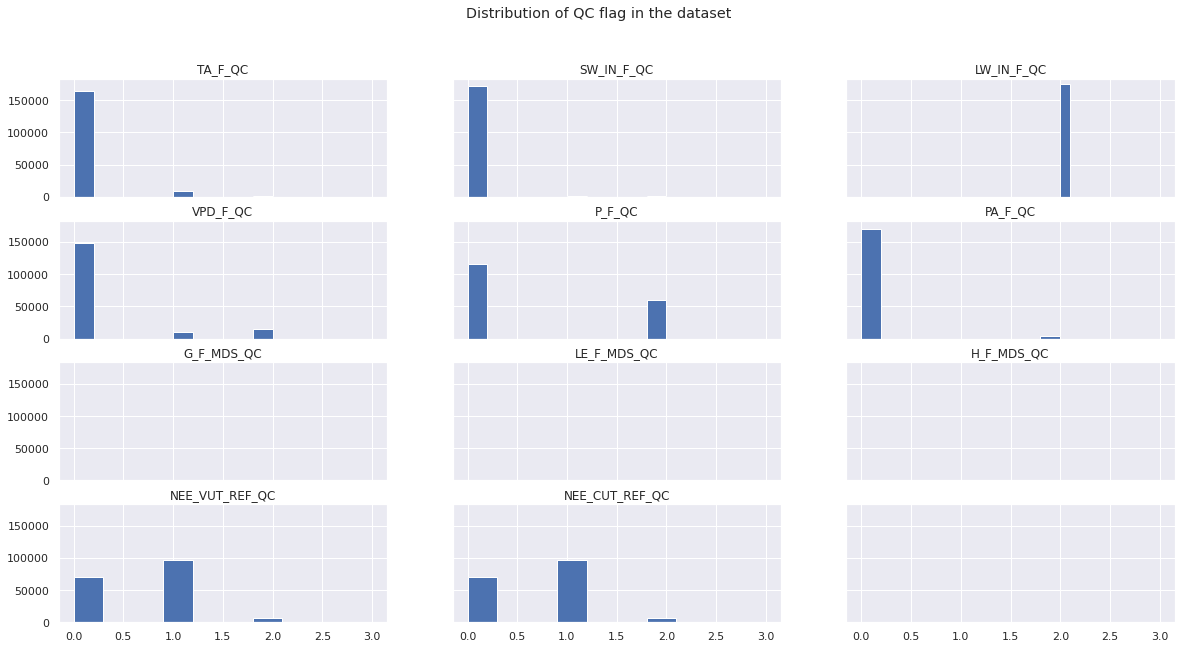

In [75]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True,figsize=(20,10))

fig.suptitle('Distribution of QC flag in the dataset')
us_vcp_hourly_df['TA_F_QC'].hist(ax=axes[0,0]).set(title='TA_F_QC')
us_vcp_hourly_df['SW_IN_F_QC'].hist(ax=axes[0,1]).set(title='SW_IN_F_QC')
us_vcp_hourly_df['LW_IN_F_QC'].hist(ax=axes[0,2]).set(title='LW_IN_F_QC')
us_vcp_hourly_df['VPD_F_QC'].hist(ax=axes[1,0]).set(title='VPD_F_QC')
us_vcp_hourly_df['P_F_QC'].hist(ax=axes[1,1]).set(title='P_F_QC')
us_vcp_hourly_df['PA_F_QC'].hist(ax=axes[1,2]).set(title='PA_F_QC')
us_vcp_hourly_df['G_F_MDS_QC'].hist(ax=axes[2,0]).set(title='G_F_MDS_QC')
us_vcp_hourly_df['LE_F_MDS_QC'].hist(ax=axes[2,1]).set(title='LE_F_MDS_QC')
us_vcp_hourly_df['H_F_MDS_QC'].hist(ax=axes[2,2]).set(title='H_F_MDS_QC')
us_vcp_hourly_df['NEE_VUT_REF_QC'].hist(ax=axes[3,0]).set(title='NEE_VUT_REF_QC')
us_vcp_hourly_df['NEE_CUT_REF_QC'].hist(ax=axes[3,1]).set(title='NEE_CUT_REF_QC')

In [76]:
# display(us_vcp_hourly_df)

## Preprocess features

In [77]:
# Original columns
print(len(us_vcp_hourly_df.columns))
us_vcp_hourly_df.columns

65


Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA_F', 'TA_F_QC', 'TA_ERA',
       'SW_IN_POT', 'SW_IN_F', 'SW_IN_F_QC', 'SW_IN_ERA', 'LW_IN_F',
       'LW_IN_F_QC', 'LW_IN_ERA', 'VPD_F', 'VPD_F_QC', 'VPD_ERA', 'P_F',
       'P_F_QC', 'P_ERA', 'PA_F', 'PA_F_QC', 'PA_ERA', 'NETRAD', 'PPFD_IN',
       'G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS', 'LE_F_MDS_QC', 'LE_CORR',
       'H_F_MDS', 'H_F_MDS_QC', 'H_CORR', 'NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF', 'datetime',
       'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'NEE_VUT_REF_qa',
       'SW_DIF', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'koppen', 'min_categorical'],
      dtype='object')

## Check how much NA/None exists in each column

In [ ]:
us_vcp_hourly_df.isna().sum()

TIMESTAMP_START        0
TIMESTAMP_END          0
TA_F                   0
TA_F_QC                0
TA_ERA                 0
                   ...  
b6                 17664
b7                 10896
IGBP                   0
koppen                 0
min_categorical        0
Length: 65, dtype: int64

In [160]:
us_vcp_hourly_countNA = us_vcp_hourly_df.isna().sum()
us_vcp_hourly_countNA

TIMESTAMP_START        0
TIMESTAMP_END          0
TA_F                   0
TA_F_QC                0
TA_ERA                 0
                   ...  
b6                 17664
b7                 10896
IGBP                   0
koppen                 0
min_categorical        0
Length: 65, dtype: int64

In [161]:
us_vcp_hourly_countNA = pd.DataFrame(us_vcp_hourly_df.isna().sum())

NA0_list = list(us_vcp_hourly_countNA[us_vcp_hourly_countNA[0] == 0].index)
NA_list = list(us_vcp_hourly_countNA[us_vcp_hourly_countNA[0] != 0].index)

In [164]:
us_vcp_hourly_countNA[us_vcp_hourly_countNA[0] != 0]

,0
NETRAD,50346
PPFD_IN,13861
G_F_MDS,174528
G_F_MDS_QC,174528
LE_F_MDS_QC,174528
LE_CORR,174528
H_F_MDS_QC,174528
H_CORR,174528
NEE_VUT_REF_qa,7628
SW_DIF,174528


In [163]:
# NA list in site us_vcp
NA_list = ['G_F_MDS', 'G_F_MDS_QC', 'LE_F_MDS_QC', 'LE_CORR', 'H_F_MDS_QC',
           'H_CORR','SW_DIF']

['NETRAD',
 'PPFD_IN',
 'G_F_MDS',
 'G_F_MDS_QC',
 'LE_F_MDS_QC',
 'LE_CORR',
 'H_F_MDS_QC',
 'H_CORR',
 'NEE_VUT_REF_qa',
 'SW_DIF',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7']

In [174]:
# Features used for this analysis
output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF',
       'NEE_VUT_REF_qa']

predictor_var = ['TA_F', 'TA_ERA','SW_IN_POT', 'SW_IN_F','SW_IN_ERA',
                 'LW_IN_F','LW_IN_ERA', 'VPD_F', 'VPD_ERA',
                 'P_F','P_ERA', 'PA_F',  'PA_ERA', 'NETRAD', 'PPFD_IN',
                 'LE_F_MDS', 'H_F_MDS', 'EVI', 'NDVI', 'NIRv',
                 'b1', 'b2', 'b3', 'b4', 'b5', 'b6','b7']

other_var =  ['TIMESTAMP_START', 'TIMESTAMP_END', 'datetime',
              'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'IGBP',
              'koppen']

qc_flags = ['TA_F_QC','SW_IN_F_QC','LW_IN_F_QC','VPD_F_QC',
            'P_F_QC', 'PA_F_QC','G_F_MDS_QC', 'LE_F_MDS_QC',
            'H_F_MDS_QC'] 

NA_list = ['G_F_MDS', 'LE_CORR', 'H_CORR','SW_DIF']
           # 'G_F_MDS_QC', 'LE_F_MDS_QC', 'H_F_MDS_QC' is skipped because they are included in qc flags
len(output_related_var + predictor_var + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

64

In [79]:
# Check if all the features are included in one of the four
total = output_related_var + predictor_var + other_var + qc_flags
for i in us_vcp_hourly_df.columns:
  if i not in total:
    print(i)

min_categorical


### Predictor variables(candidates)

| feature name |     source    |                                                              definition                                                              |
|:------------:|:-------------:|:------------------------------------------------------------------------------------------------------------------------------------:|
| TA_F         |    FLUXNET    | Air temperature, consolidated from TA_F_MDS and TA_ERA                                                                               |
| TA_ERA       |    FLUXNET    | Air temperature, downscaled from ERA, linearly regressed using measured only site data                                               |
| SW_IN_POT    |    FLUXNET    | Shortwave radiation, incoming, potential (top of atmosphere)                                                                         |
| SW_IN_F      |    FLUXNET    | Shortwave radiation,  incoming consolidated from SW_IN_F_MDS and SW_IN_ERA (negative values set to zero)                             |
| SW_IN_ERA    |    FLUXNET    | Shortwave radiation, incoming, downscaled from ERA,  linearly regressed using measured only site data  (negative values set to zero) |
| LW_IN_F      |    FLUXNET    | Longwave radiation, incoming, consolidated from LW_IN_F_MDS and LW_IN_ERA                                                            |
| LW_IN_ERA    |    FLUXNET    | Longwave radiation, incoming, downscaled from ERA, linearly regressed using measured only site data                                  |
| VPD_F        |    FLUXNET    | N/A                                                                                                                                  |
| VPD_ERA      |    FLUXNET    | Vapor Pressure Deficit, downscaled from ERA, linearly regressed using measured only site data                                        |
| P_F          |    FLUXNET    | Precipitation consolidated from P and P_ERA                                                                                          |
| P_ERA        |    FLUXNET    | Precipitation, downscaled from ERA, linearly regressed using measured only site data                                                 |
| PA_F         |    FLUXNET    | Atmospheric pressure consolidated from PA and PA_ERA                                                                                 |
| PA_ERA       |    FLUXNET    | Atmospheric pressure, downscaled from ERA, linearly regressed using measured only site data                                          |
| NETRAD       |    FLUXNET    | Net radiation                                                                                                                        |
| PPFD_IN      |    FLUXNET    | Photosynthetic photon flux density, incoming                                                                                         |
| G_F_MDS      |    FLUXNET    | Soil heat flux                                                                                                                       |
| LE_F_MDS     |    FLUXNET    | Latent heat flux, gapfilled using MDS method                                                                                         |
| LE_CORR      |    FLUXNET    | Latent heat flux, corrected LE_F_MDS by energy balance closure correction factor                                                     |
| H_F_MDS      |    FLUXNET    | Sensible heat flux, gapfilled using MDS method                                                                                       |
| H_CORR       |    FLUXNET    | Sensible heat flux, corrected H_F_MDS by energy balance closure correction factor                                                    |
| SW_DIF       |    FLUXNET    | Shortwave radiation, diffuse incoming                                                                                                |
| EVI          |    MCD43C4    | Enhanced Vegetation Index (EVI)                                                                                                      |
| NDVI         |    MCD43C4    | Normalized Difference Vegetation Index (NDVI)                                                                                        |
| NIRv         |    MCD43C4    | NIRv d                                                                                                                               |
| b1           |    MCD43C4    | Surface reflectance Band 1                                                                                                           |
| b2           |    MCD43C4    | Surface reflectance Band 2 (nir)                                                                                                     |
| b3           |    MCD43C4    | Surface reflectance Band 3 (blue)                                                                                                    |
| b4           |    MCD43C4    | Surface reflectance Band 4 (green)                                                                                                   |
| b5           |    MCD43C4    | Surface reflectance Band 5 (SWIR1)                                                                                                   |
| b6           |    MCD43C4    | Surface reflectance Band 6 (SWIR2)                                                                                                   |
| b7           |    MCD43C4    | Surface reflectance Band 7 (SWIR3)                                                                                                   |
| koppen       | Koppen-Geiger | Climate zone (one-hot encoding)                                                                                                      |

# Correlation with time
- month 
- hour

## Correlation by month

[Text(0.5, 1.0, 'GPP_NT_VUT_REF')]

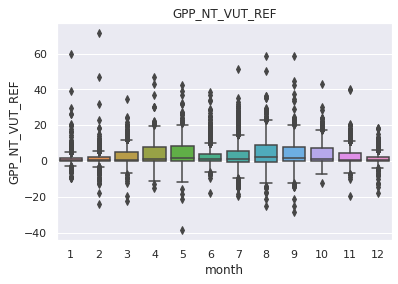

In [80]:
sns.boxplot(data=us_vcp_hourly_00_df, x='month', y='GPP_NT_VUT_REF').set(title='GPP_NT_VUT_REF')

## Correlation by hour

[Text(0.5, 1.0, 'GPP_NT_VUT_REF')]

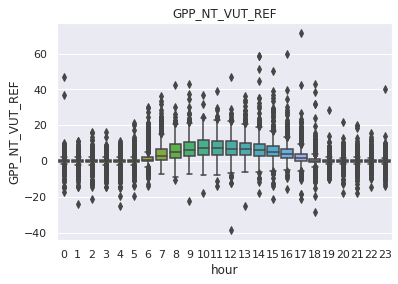

In [81]:
sns.boxplot(data=us_vcp_hourly_00_df, x='hour', y='GPP_NT_VUT_REF').set(title='GPP_NT_VUT_REF')

## Correlation by hour and month

[Text(0.5, 1.0, 'December')]

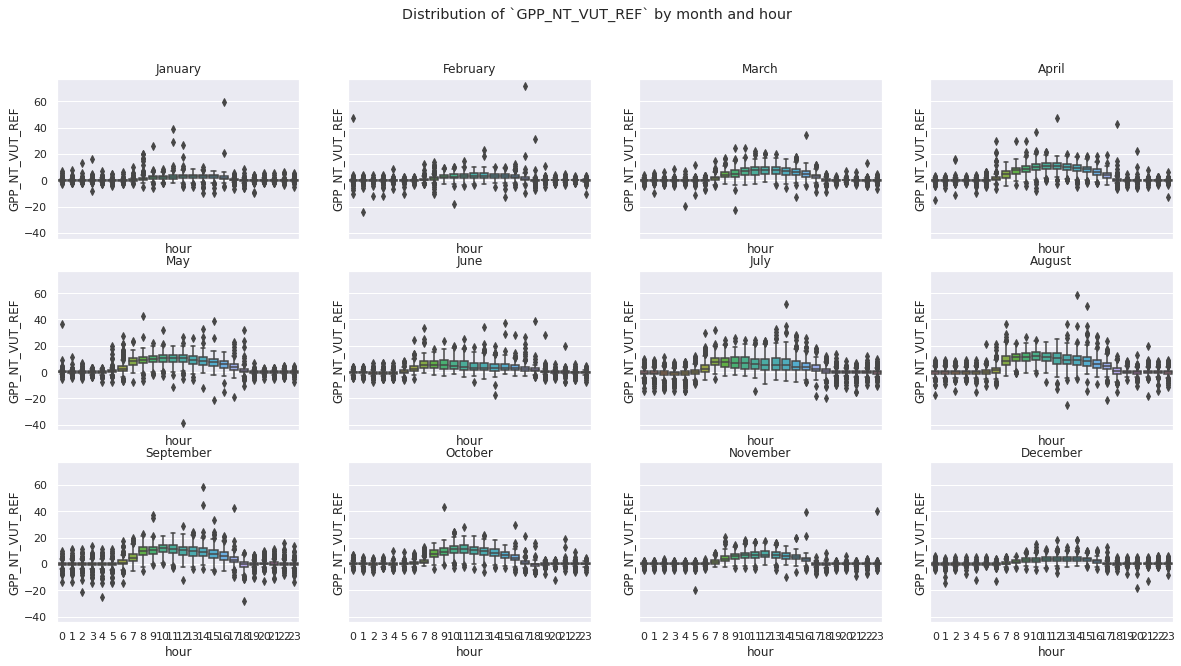

In [82]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of `GPP_NT_VUT_REF` by month and hour')
sns.boxplot(ax=axes[0, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 1], x='hour', y='GPP_NT_VUT_REF').set(title='January')
sns.boxplot(ax=axes[0, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 2], x='hour', y='GPP_NT_VUT_REF').set(title='February')
sns.boxplot(ax=axes[0, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 3], x='hour', y='GPP_NT_VUT_REF').set(title='March')
sns.boxplot(ax=axes[0, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 4], x='hour', y='GPP_NT_VUT_REF').set(title='April')
sns.boxplot(ax=axes[1, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 5], x='hour', y='GPP_NT_VUT_REF').set(title='May')
sns.boxplot(ax=axes[1, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 6], x='hour', y='GPP_NT_VUT_REF').set(title='June')
sns.boxplot(ax=axes[1, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 7], x='hour', y='GPP_NT_VUT_REF').set(title='July')
sns.boxplot(ax=axes[1, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 8], x='hour', y='GPP_NT_VUT_REF').set(title='August')
sns.boxplot(ax=axes[2, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 9], x='hour', y='GPP_NT_VUT_REF').set(title='September')
sns.boxplot(ax=axes[2, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 10], x='hour', y='GPP_NT_VUT_REF').set(title='October')
sns.boxplot(ax=axes[2, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 11], x='hour', y='GPP_NT_VUT_REF').set(title='November')
sns.boxplot(ax=axes[2, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 12], x='hour', y='GPP_NT_VUT_REF').set(title='December')


[Text(0.5, 1.0, 'December')]

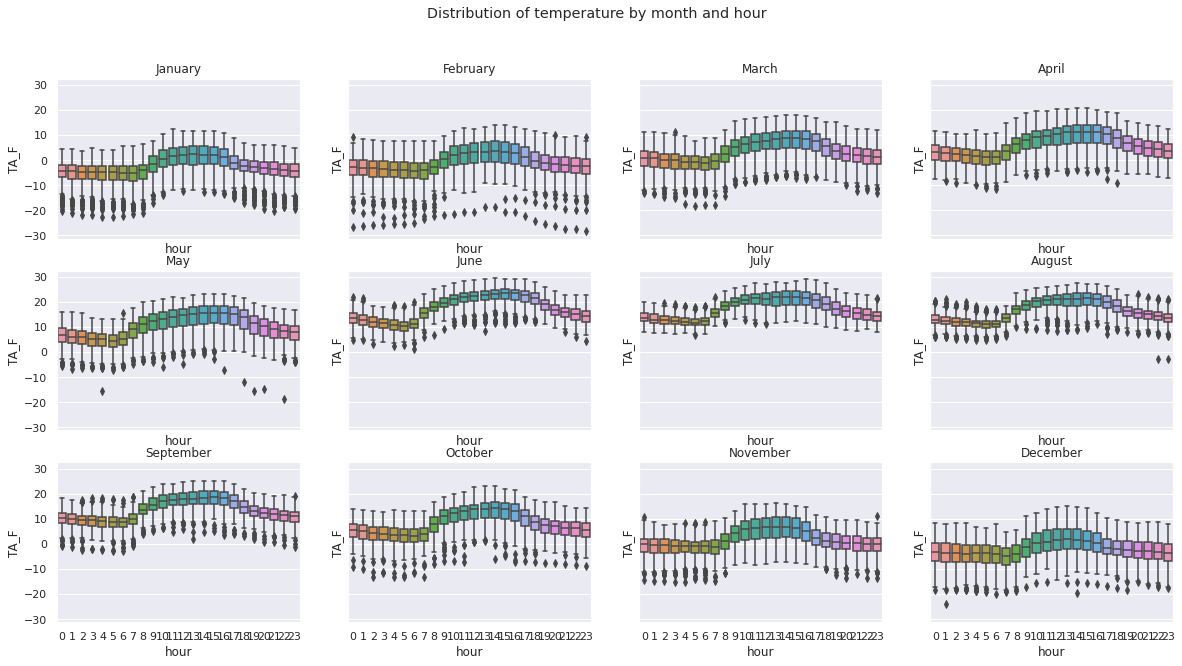

In [83]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True,figsize=(20,10))
fig.suptitle('Distribution of temperature by month and hour')
sns.boxplot(ax=axes[0, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 1], x='hour', y='TA_F').set(title='January')
sns.boxplot(ax=axes[0, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 2], x='hour', y='TA_F').set(title='February')
sns.boxplot(ax=axes[0, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 3], x='hour', y='TA_F').set(title='March')
sns.boxplot(ax=axes[0, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 4], x='hour', y='TA_F').set(title='April')
sns.boxplot(ax=axes[1, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 5], x='hour', y='TA_F').set(title='May')
sns.boxplot(ax=axes[1, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 6], x='hour', y='TA_F').set(title='June')
sns.boxplot(ax=axes[1, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 7], x='hour', y='TA_F').set(title='July')
sns.boxplot(ax=axes[1, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 8], x='hour', y='TA_F').set(title='August')
sns.boxplot(ax=axes[2, 0], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 9], x='hour', y='TA_F').set(title='September')
sns.boxplot(ax=axes[2, 1], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 10], x='hour', y='TA_F').set(title='October')
sns.boxplot(ax=axes[2, 2], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 11], x='hour', y='TA_F').set(title='November')
sns.boxplot(ax=axes[2, 3], data=us_vcp_hourly_00_df[us_vcp_hourly_00_df['month'] == 12], x='hour', y='TA_F').set(title='December')


---
*Following process use only Spark(N0 PANDAS)*

# Use parquet -> Spark df as preparation for global data

## DF to Parquet format
- Pandas is converted to parquet in order to make the following code usable with global data in AWS

In [84]:
type(us_vcp_hourly_00_df)

pandas.core.frame.DataFrame

### Method 1

In [85]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
us_vcp_hourly_00_df.to_parquet('us_vcp_hourly_00_pq', engine='fastparquet')
us_vcp_hourly_df.to_parquet('us_vcp_hourly_pq', engine='fastparquet')

### Method 2

In [87]:
# Convert df to parquet
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
table = pa.Table.from_pandas(us_vcp_hourly_00_df)
# Second, write the table into parquet file say file_name.parquet
# Parquet with Brotli compression
pq.write_table(table, 'us_vcp_hourly_00_pq.parquet')

## parquet to Spark df 

In [117]:
# Parquet is read from 
# When running Spark in AWS through the access to Azure, update the location and file name 
us_vcp_hourly_00_sdf = spark.read.parquet('us_vcp_hourly_00_pq')
us_vcp_hourly_00_sdf2 = spark.read.parquet('us_vcp_hourly_00_pq.parquet')
us_vcp_hourly_sdf = spark.read.parquet('us_vcp_hourly_pq')

In [195]:
us_vcp_hourly_00_sdf.printSchema()

root
 |-- index: long (nullable = true)
 |-- TIMESTAMP_START: long (nullable = true)
 |-- TIMESTAMP_END: long (nullable = true)
 |-- TA_F: double (nullable = true)
 |-- TA_F_QC: long (nullable = true)
 |-- TA_ERA: double (nullable = true)
 |-- SW_IN_POT: double (nullable = true)
 |-- SW_IN_F: double (nullable = true)
 |-- SW_IN_F_QC: long (nullable = true)
 |-- SW_IN_ERA: double (nullable = true)
 |-- LW_IN_F: double (nullable = true)
 |-- LW_IN_F_QC: double (nullable = true)
 |-- LW_IN_ERA: double (nullable = true)
 |-- VPD_F: double (nullable = true)
 |-- VPD_F_QC: long (nullable = true)
 |-- VPD_ERA: double (nullable = true)
 |-- P_F: double (nullable = true)
 |-- P_F_QC: double (nullable = true)
 |-- P_ERA: double (nullable = true)
 |-- PA_F: double (nullable = true)
 |-- PA_F_QC: double (nullable = true)
 |-- PA_ERA: double (nullable = true)
 |-- NETRAD: double (nullable = true)
 |-- PPFD_IN: double (nullable = true)
 |-- G_F_MDS: double (nullable = true)
 |-- G_F_MDS_QC: double (

In [196]:
us_vcp_hourly_00_sdf.show(truncate=False)

+-----+---------------+-------------+------+-------+-------+---------+-------+----------+---------+-------+----------+---------+-----+--------+-------+---+------+-----+------+-------+------+----------+-------+-------+----------+---------+-----------+-------+--------+----------+------+-----------+--------------+-----------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+-------------------+----+-----+---+----+-------+----------+--------------+------+------------------+------------------+------------------+------+------+-----+------+------+------+------+----+------+---------------+
|index|TIMESTAMP_START|TIMESTAMP_END|TA_F  |TA_F_QC|TA_ERA |SW_IN_POT|SW_IN_F|SW_IN_F_QC|SW_IN_ERA|LW_IN_F|LW_IN_F_QC|LW_IN_ERA|VPD_F|VPD_F_QC|VPD_ERA|P_F|P_F_QC|P_ERA|PA_F  |PA_F_QC|PA_ERA|NETRAD    |PPFD_IN|G_F_MDS|G_F_MDS_QC|LE_F_MDS |LE_F_MDS_QC|LE_CORR|H_F_MDS |H_F_MDS_QC|H_CORR|NEE_VUT_REF|NEE_VUT_REF_QC|NEE_CUT_RE

In [100]:
display(us_vcp_hourly_00_sdf)

DataFrame[index: bigint, TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double

In [101]:
us_vcp_hourly_00_sdf

DataFrame[index: bigint, TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double

In [102]:
us_vcp_hourly_00_sdf2

DataFrame[TIMESTAMP_START: bigint, TIMESTAMP_END: bigint, TA_F: double, TA_F_QC: bigint, TA_ERA: double, SW_IN_POT: double, SW_IN_F: double, SW_IN_F_QC: bigint, SW_IN_ERA: double, LW_IN_F: double, LW_IN_F_QC: double, LW_IN_ERA: double, VPD_F: double, VPD_F_QC: bigint, VPD_ERA: double, P_F: double, P_F_QC: double, P_ERA: double, PA_F: double, PA_F_QC: double, PA_ERA: double, NETRAD: double, PPFD_IN: double, G_F_MDS: double, G_F_MDS_QC: double, LE_F_MDS: double, LE_F_MDS_QC: double, LE_CORR: double, H_F_MDS: double, H_F_MDS_QC: double, H_CORR: double, NEE_VUT_REF: double, NEE_VUT_REF_QC: double, NEE_CUT_REF: double, NEE_CUT_REF_QC: double, GPP_NT_VUT_REF: double, GPP_DT_VUT_REF: double, GPP_NT_CUT_REF: double, GPP_DT_CUT_REF: double, RECO_NT_VUT_REF: double, RECO_DT_VUT_REF: double, RECO_NT_CUT_REF: double, RECO_DT_CUT_REF: double, datetime: string, year: bigint, month: bigint, day: bigint, hour: bigint, SITE_ID: string, date: string, NEE_VUT_REF_qa: double, SW_DIF: double, EVI: double, 

In [118]:
print(type(us_vcp_hourly_00_sdf))
print(type(us_vcp_hourly_00_sdf2))
print(type(us_vcp_hourly_sdf))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


# Correlation among features with pyspark

In [105]:
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

In [120]:
us_vcp_hourly_00_sdf.columns

['index',
 'TIMESTAMP_START',
 'TIMESTAMP_END',
 'TA_F',
 'TA_F_QC',
 'TA_ERA',
 'SW_IN_POT',
 'SW_IN_F',
 'SW_IN_F_QC',
 'SW_IN_ERA',
 'LW_IN_F',
 'LW_IN_F_QC',
 'LW_IN_ERA',
 'VPD_F',
 'VPD_F_QC',
 'VPD_ERA',
 'P_F',
 'P_F_QC',
 'P_ERA',
 'PA_F',
 'PA_F_QC',
 'PA_ERA',
 'NETRAD',
 'PPFD_IN',
 'G_F_MDS',
 'G_F_MDS_QC',
 'LE_F_MDS',
 'LE_F_MDS_QC',
 'LE_CORR',
 'H_F_MDS',
 'H_F_MDS_QC',
 'H_CORR',
 'NEE_VUT_REF',
 'NEE_VUT_REF_QC',
 'NEE_CUT_REF',
 'NEE_CUT_REF_QC',
 'GPP_NT_VUT_REF',
 'GPP_DT_VUT_REF',
 'GPP_NT_CUT_REF',
 'GPP_DT_CUT_REF',
 'RECO_NT_VUT_REF',
 'RECO_DT_VUT_REF',
 'RECO_NT_CUT_REF',
 'RECO_DT_CUT_REF',
 'datetime',
 'year',
 'month',
 'day',
 'hour',
 'SITE_ID',
 'date',
 'NEE_VUT_REF_qa',
 'SW_DIF',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7',
 'IGBP',
 'koppen',
 'min_categorical']

## Choose features to see correlations

In [175]:
# Features used for this analysis
output_var = 'GPP_NT_VUT_REF'
# other options
output_related_var = ['NEE_VUT_REF', 'NEE_VUT_REF_QC',
       'NEE_CUT_REF', 'NEE_CUT_REF_QC', 'GPP_NT_VUT_REF', 'GPP_DT_VUT_REF',
       'GPP_NT_CUT_REF', 'GPP_DT_CUT_REF', 'RECO_NT_VUT_REF',
       'RECO_DT_VUT_REF', 'RECO_NT_CUT_REF', 'RECO_DT_CUT_REF',
       'NEE_VUT_REF_qa']

predictor_var = ['TA_F', 'TA_ERA','SW_IN_POT', 'SW_IN_F','SW_IN_ERA',
                 'LW_IN_F','LW_IN_ERA', 'VPD_F', 'VPD_ERA',
                 'P_F','P_ERA', 'PA_F',  'PA_ERA', 'NETRAD', 'PPFD_IN',
                 'LE_F_MDS', 'H_F_MDS', 'EVI', 'NDVI', 'NIRv',
                 'b1', 'b2', 'b3', 'b4', 'b5', 'b6','b7']

other_var =  ['TIMESTAMP_START', 'TIMESTAMP_END', 'datetime',
              'year', 'month', 'day', 'hour', 'SITE_ID', 'date', 'IGBP',
              'koppen']

qc_flags = ['TA_F_QC','SW_IN_F_QC','LW_IN_F_QC','VPD_F_QC',
            'P_F_QC', 'PA_F_QC','G_F_MDS_QC', 'LE_F_MDS_QC',
            'H_F_MDS_QC'] 

NA_list = ['G_F_MDS', 'LE_CORR', 'H_CORR','SW_DIF']
           # 'G_F_MDS_QC', 'LE_F_MDS_QC', 'H_F_MDS_QC' is skipped because they are included in qc flags
len(output_related_var + predictor_var + other_var + qc_flags + NA_list)
# output_var is included in output_related_var

64

In [194]:
# Features to observe correlation
corr_list = [output_var] + predictor_var 

## Result of XX:00 Spark df

In [177]:
us_vcp_hourly_00_corr = us_vcp_hourly_00_sdf.select(corr_list)

col_names = us_vcp_hourly_00_corr.columns
features = us_vcp_hourly_00_corr.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_00_df = pd.DataFrame(corr_mat)
corr_00_df.index, corr_00_df.columns = col_names, col_names
corr_00_df

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.362081,0.325296,0.708385,0.694869,0.689599,0.173476,0.173476,0.330677,0.270798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_F,0.362081,1.000000,0.954873,0.462735,0.436773,0.441354,0.731905,0.731905,0.801470,0.825109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_ERA,0.325296,0.954873,1.000000,0.436220,0.374789,0.405300,0.781624,0.781624,0.735586,0.860532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_POT,0.708385,0.462735,0.436220,1.000000,0.891480,0.973291,0.213049,0.213049,0.531359,0.465147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_F,0.694869,0.436773,0.374789,0.891480,1.000000,0.927453,0.082973,0.082973,0.559651,0.423814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_ERA,0.689599,0.441354,0.405300,0.973291,0.927453,1.000000,0.123711,0.123711,0.541782,0.457675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_F,0.173476,0.731905,0.781624,0.213049,0.082973,0.123711,1.000000,1.000000,0.362522,0.515129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_ERA,0.173476,0.731905,0.781624,0.213049,0.082973,0.123711,1.000000,1.000000,0.362522,0.515129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_F,0.330677,0.801470,0.735586,0.531359,0.559651,0.541782,0.362522,0.362522,1.000000,0.871168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_ERA,0.270798,0.825109,0.860532,0.465147,0.423814,0.457675,0.515129,0.515129,0.871168,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Result of full df

In [178]:
us_vcp_hourly_corr = us_vcp_hourly_sdf.select(corr_list)

col_names = us_vcp_hourly_corr.columns
features = us_vcp_hourly_corr.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
corr_df

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.363963,0.325968,0.709382,0.696132,0.690248,0.169386,0.169386,0.332618,0.271632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_F,0.363963,1.000000,0.954724,0.462712,0.436966,0.444696,0.729843,0.729843,0.801394,0.825568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA_ERA,0.325968,0.954724,1.000000,0.435276,0.373838,0.408707,0.781416,0.781416,0.735037,0.860699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_POT,0.709382,0.462712,0.435276,1.000000,0.891512,0.974397,0.207895,0.207895,0.531181,0.464416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_F,0.696132,0.436966,0.373838,0.891512,1.000000,0.927246,0.078255,0.078255,0.559866,0.423237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SW_IN_ERA,0.690248,0.444696,0.408707,0.974397,0.927246,1.000000,0.120790,0.120790,0.545870,0.462723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_F,0.169386,0.729843,0.781416,0.207895,0.078255,0.120790,1.000000,1.000000,0.360058,0.514064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LW_IN_ERA,0.169386,0.729843,0.781416,0.207895,0.078255,0.120790,1.000000,1.000000,0.360058,0.514064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_F,0.332618,0.801394,0.735037,0.531181,0.559866,0.545870,0.360058,0.360058,1.000000,0.871041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VPD_ERA,0.271632,0.825568,0.860699,0.464416,0.423237,0.462723,0.514064,0.514064,0.871041,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
type(us_vcp_hourly_corr)

pyspark.sql.dataframe.DataFrame

## Divide feature with None and feature without None

In [180]:
display(us_vcp_hourly_corr.head(5))

[Row(GPP_NT_VUT_REF=-0.178472, TA_F=-7.706, TA_ERA=-9.299, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=202.327, LW_IN_ERA=202.327, VPD_F=0.484, VPD_ERA=1.58, P_F=0.0, P_ERA=0.0, PA_F=75.633, PA_ERA=75.452, NETRAD=-84.713875, PPFD_IN=None, LE_F_MDS=0.874446, H_F_MDS=-29.7952, EVI=0.3052561641813081, NDVI=0.3364524003254678, NIRv=0.1105246135069162, b1=0.1631, b2=0.3285, b3=0.127, b4=0.1362, b5=0.1932, b6=0.0567, b7=0.0283),
 Row(GPP_NT_VUT_REF=-0.197405, TA_F=-8.095, TA_ERA=-9.672, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=202.327, LW_IN_ERA=202.327, VPD_F=0.395, VPD_ERA=1.553, P_F=0.0, P_ERA=0.0, PA_F=75.614, PA_ERA=75.443, NETRAD=-80.137327, PPFD_IN=None, LE_F_MDS=0.757796, H_F_MDS=-25.9238, EVI=0.3052561641813081, NDVI=0.3364524003254678, NIRv=0.1105246135069162, b1=0.1631, b2=0.3285, b3=0.127, b4=0.1362, b5=0.1932, b6=0.0567, b7=0.0283),
 Row(GPP_NT_VUT_REF=-0.170178, TA_F=-8.582, TA_ERA=-10.044, SW_IN_POT=0.0, SW_IN_F=0.0, SW_IN_ERA=0.0, LW_IN_F=202.327, LW_IN_ERA=2

In [181]:
# code that counts the number of None in each feature
from pyspark.sql.functions import isnull, when, count, col

us_vcp_hourly_corr.select([count(when(isnull(c), c)).alias(c) for c in us_vcp_hourly_corr.columns]).show()

+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|GPP_NT_VUT_REF|TA_F|TA_ERA|SW_IN_POT|SW_IN_F|SW_IN_ERA|LW_IN_F|LW_IN_ERA|VPD_F|VPD_ERA|P_F|P_ERA|PA_F|PA_ERA|NETRAD|PPFD_IN|LE_F_MDS|H_F_MDS|  EVI| NDVI| NIRv|   b1|   b2|   b3|   b4|   b5|   b6|   b7|
+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|             0|   0|     0|        0|      0|        0|      0|        0|    0|      0|  0|    0|   0|     0| 50346|  13861|       0|      0|10992|10944|10944|10944|10896|10992|10944|12240|17664|10896|
+--------------+----+------+---------+-------+---------+-------+---------+-----+-------+---+-----+----+------+------+-------+--------+-------+-----+-----+-----+-----+-----+-----+-----+----

## Create two lists - list of features with noNA/NA

In [182]:
us_vcp_hourly_00_countNA = pd.DataFrame(us_vcp_hourly_00_df[corr_list].isna().sum())
us_vcp_hourly_countNA = pd.DataFrame(us_vcp_hourly_df[corr_list].isna().sum())

corr_NA0_list = list(us_vcp_hourly_00_countNA[us_vcp_hourly_00_countNA[0] == 0].index)
corr_NA_list = list(us_vcp_hourly_00_countNA[us_vcp_hourly_00_countNA[0] != 0].index)

In [183]:
corr_NA_list

['NETRAD',
 'PPFD_IN',
 'EVI',
 'NDVI',
 'NIRv',
 'b1',
 'b2',
 'b3',
 'b4',
 'b5',
 'b6',
 'b7']

In [184]:
corr_NA0_list

['GPP_NT_VUT_REF',
 'TA_F',
 'TA_ERA',
 'SW_IN_POT',
 'SW_IN_F',
 'SW_IN_ERA',
 'LW_IN_F',
 'LW_IN_ERA',
 'VPD_F',
 'VPD_ERA',
 'P_F',
 'P_ERA',
 'PA_F',
 'PA_ERA',
 'LE_F_MDS',
 'H_F_MDS']

## Correlation of features with zero NA

In [185]:
us_vcp_hourly_corr2 = us_vcp_hourly_sdf.select(corr_NA0_list)

col_names = us_vcp_hourly_corr2.columns
features = us_vcp_hourly_corr2.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df2 = pd.DataFrame(corr_mat)
corr_df2.index, corr_df2.columns = col_names, col_names
corr_df2

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,P_F,P_ERA,PA_F,PA_ERA,LE_F_MDS,H_F_MDS
GPP_NT_VUT_REF,1.000000,0.363963,0.325968,0.709382,0.696132,0.690248,0.169386,0.169386,0.332618,0.271632,0.004177,0.006533,0.080787,0.118404,0.680946,0.572644
TA_F,0.363963,1.000000,0.954724,0.462712,0.436966,0.444696,0.729843,0.729843,0.801394,0.825568,-0.001091,-0.018992,0.388989,0.399002,0.482146,0.347596
TA_ERA,0.325968,0.954724,1.000000,0.435276,0.373838,0.408707,0.781416,0.781416,0.735037,0.860699,0.019248,-0.007992,0.379748,0.363334,0.456912,0.301026
SW_IN_POT,0.709382,0.462712,0.435276,1.000000,0.891512,0.974397,0.207895,0.207895,0.531181,0.464416,0.052545,0.029278,0.045064,0.078872,0.768606,0.814241
SW_IN_F,0.696132,0.436966,0.373838,0.891512,1.000000,0.927246,0.078255,0.078255,0.559866,0.423237,-0.016797,-0.029419,0.061623,0.108271,0.738103,0.933067
SW_IN_ERA,0.690248,0.444696,0.408707,0.974397,0.927246,1.000000,0.120790,0.120790,0.545870,0.462723,0.020875,-0.016252,0.048798,0.085601,0.746142,0.862935
LW_IN_F,0.169386,0.729843,0.781416,0.207895,0.078255,0.120790,1.000000,1.000000,0.360058,0.514064,0.102654,0.156871,0.312150,0.283775,0.303953,0.017740
LW_IN_ERA,0.169386,0.729843,0.781416,0.207895,0.078255,0.120790,1.000000,1.000000,0.360058,0.514064,0.102654,0.156871,0.312150,0.283775,0.303953,0.017740
VPD_F,0.332618,0.801394,0.735037,0.531181,0.559866,0.545870,0.360058,0.360058,1.000000,0.871041,-0.061441,-0.072980,0.200197,0.218746,0.474929,0.504355
VPD_ERA,0.271632,0.825568,0.860699,0.464416,0.423237,0.462723,0.514064,0.514064,0.871041,1.000000,-0.025815,-0.084066,0.281251,0.261730,0.443210,0.367848


## Correlation table 1 - full observations
 - None of the observations are dropped because of NA 

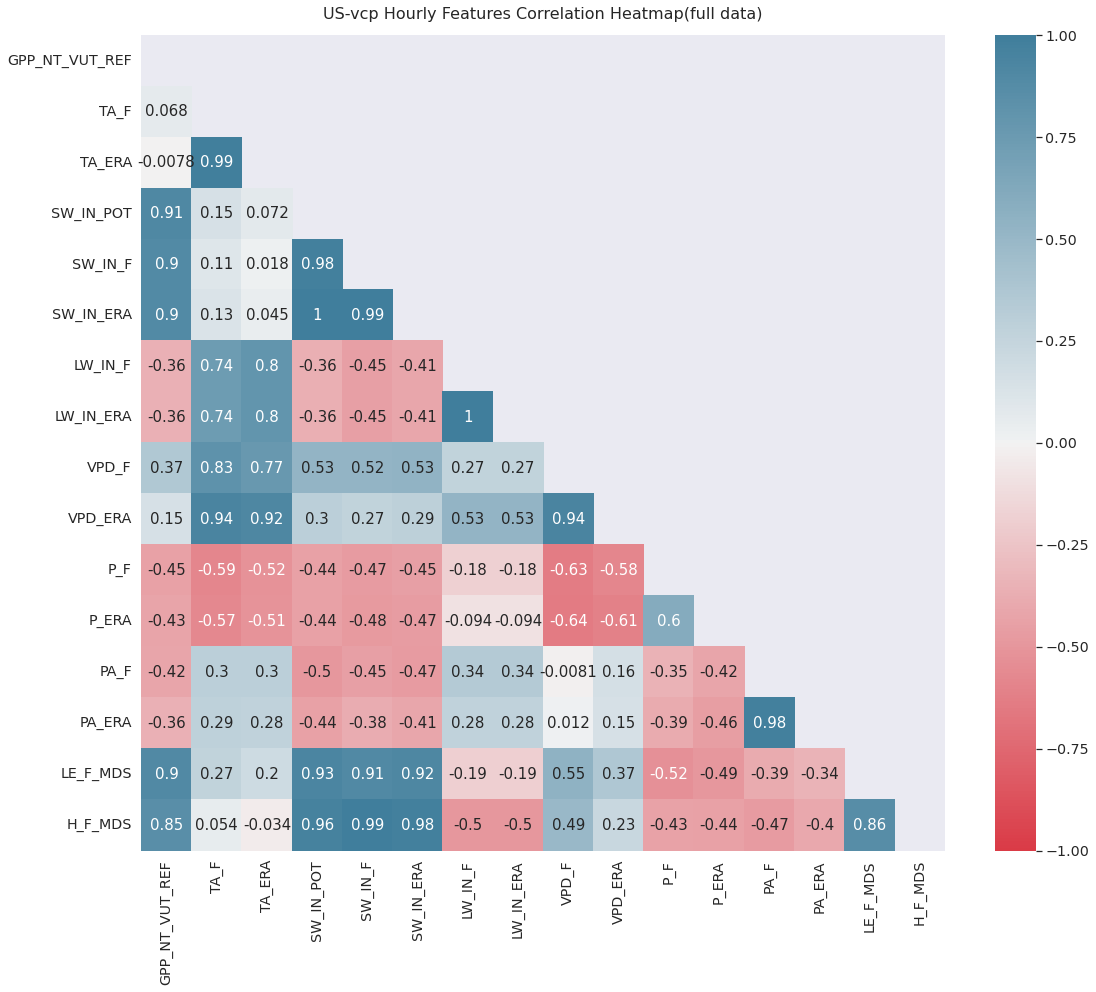

In [189]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df2)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

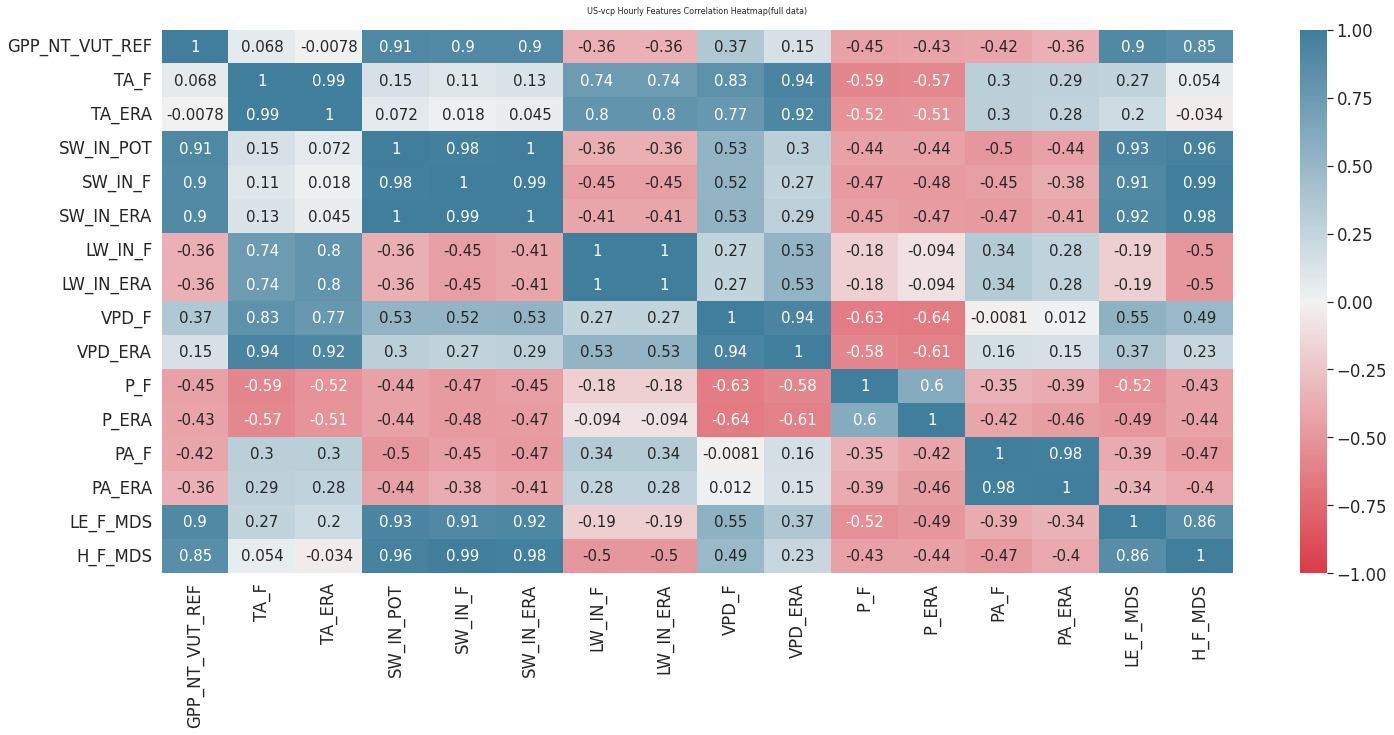

In [192]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df2.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":15})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(full data)', fontdict={'fontsize':8}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')


## Correlation table 2 - drop rows with NA

In [193]:
us_vcp_hourly_corr3 = us_vcp_hourly_sdf.select(corr_list)

### Drop NA-contained rows

In [201]:
us_vcp_hourly_corr3_NAdrop = us_vcp_hourly_corr3.na.drop("any")
us_vcp_hourly_corr3_NAdrop.show()

+--------------+------+------+---------+-------+---------+-------+---------+-----+-------+---+-----+------+------+----------+---------+--------+--------+------------------+------------------+------------------+------+------+------+------+------+------+------+
|GPP_NT_VUT_REF|  TA_F|TA_ERA|SW_IN_POT|SW_IN_F|SW_IN_ERA|LW_IN_F|LW_IN_ERA|VPD_F|VPD_ERA|P_F|P_ERA|  PA_F|PA_ERA|    NETRAD|  PPFD_IN|LE_F_MDS| H_F_MDS|               EVI|              NDVI|              NIRv|    b1|    b2|    b3|    b4|    b5|    b6|    b7|
+--------------+------+------+---------+-------+---------+-------+---------+-----+-------+---+-----+------+------+----------+---------+--------+--------+------------------+------------------+------------------+------+------+------+------+------+------+------+
|      -3.47747|11.853|19.185|      0.0|    0.0|      0.0|316.061|  316.061|1.913| 14.306|0.0|  0.0|75.885| 75.46|-41.358245|      0.0| 5.21837|-19.2016|0.3635674035543996|0.6142813548977724|0.1624774183704607|0.0632|0.2

Rows were reduced from 174528 -> 104846

In [203]:
rows = us_vcp_hourly_corr3_NAdrop.count()
print(f"DataFrame Rows count : {rows}")

DataFrame Rows count : 104846


In [204]:
col_names = us_vcp_hourly_corr3_NAdrop.columns
features = us_vcp_hourly_corr3_NAdrop.rdd.map(lambda row:row[0:])
corr_mat = Statistics.corr(features, method='pearson')
corr_df3_NAdrop = pd.DataFrame(corr_mat)
corr_df3_NAdrop.index, corr_df3_NAdrop.columns = col_names, col_names
corr_df3_NAdrop

,GPP_NT_VUT_REF,TA_F,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_ERA,LW_IN_F,LW_IN_ERA,VPD_F,VPD_ERA,...,EVI,NDVI,NIRv,b1,b2,b3,b4,b5,b6,b7
GPP_NT_VUT_REF,1.000000,0.325532,0.272698,0.715280,0.701658,0.693729,0.121407,0.121407,0.299407,0.219708,...,0.017448,0.109214,0.084715,-0.102422,-0.044085,-0.108096,-0.096875,0.058985,0.099128,0.085443
TA_F,0.325532,1.000000,0.952708,0.457879,0.435777,0.443701,0.709971,0.709971,0.800422,0.827453,...,0.339503,0.483655,0.596135,-0.326260,0.112834,-0.360285,-0.284944,0.583804,0.533800,0.383711
TA_ERA,0.272698,0.952708,1.000000,0.412515,0.356068,0.390567,0.766886,0.766886,0.721063,0.862945,...,0.359861,0.526988,0.643675,-0.357125,0.116493,-0.395571,-0.314862,0.626079,0.573647,0.412386
SW_IN_POT,0.715280,0.457879,0.412515,1.000000,0.898393,0.975627,0.165638,0.165638,0.539018,0.449136,...,0.038792,0.032007,0.092527,-0.019404,0.055376,-0.050608,-0.022478,0.175261,0.184991,0.177023
SW_IN_F,0.701658,0.435777,0.356068,0.898393,1.000000,0.931794,0.041838,0.041838,0.566439,0.413050,...,0.018215,0.014478,0.060790,-0.014028,0.037894,-0.041984,-0.018137,0.138106,0.151616,0.149526
SW_IN_ERA,0.693729,0.443701,0.390567,0.975627,0.931794,1.000000,0.082943,0.082943,0.557100,0.452350,...,0.022956,0.010606,0.072186,-0.007767,0.053890,-0.042895,-0.013975,0.171618,0.185920,0.184328
LW_IN_F,0.121407,0.709971,0.766886,0.165638,0.041838,0.082943,1.000000,1.000000,0.304254,0.479877,...,0.388532,0.505379,0.613963,-0.308869,0.132109,-0.312691,-0.255024,0.505461,0.412876,0.247238
LW_IN_ERA,0.121407,0.709971,0.766886,0.165638,0.041838,0.082943,1.000000,1.000000,0.304254,0.479877,...,0.388532,0.505379,0.613963,-0.308869,0.132109,-0.312691,-0.255024,0.505461,0.412876,0.247238
VPD_F,0.299407,0.800422,0.721063,0.539018,0.566439,0.557100,0.304254,0.304254,1.000000,0.865984,...,0.179367,0.200631,0.320667,-0.127310,0.120864,-0.174322,-0.116561,0.427746,0.399160,0.327971
VPD_ERA,0.219708,0.827453,0.862945,0.449136,0.413050,0.452350,0.479877,0.479877,0.865984,1.000000,...,0.309478,0.324850,0.488894,-0.186436,0.182623,-0.226757,-0.155741,0.535692,0.451696,0.330356


## Correlation table 2 - NA dropped
 - Apply all the possible features
 - Instead, row that include NA are dropped from DF 

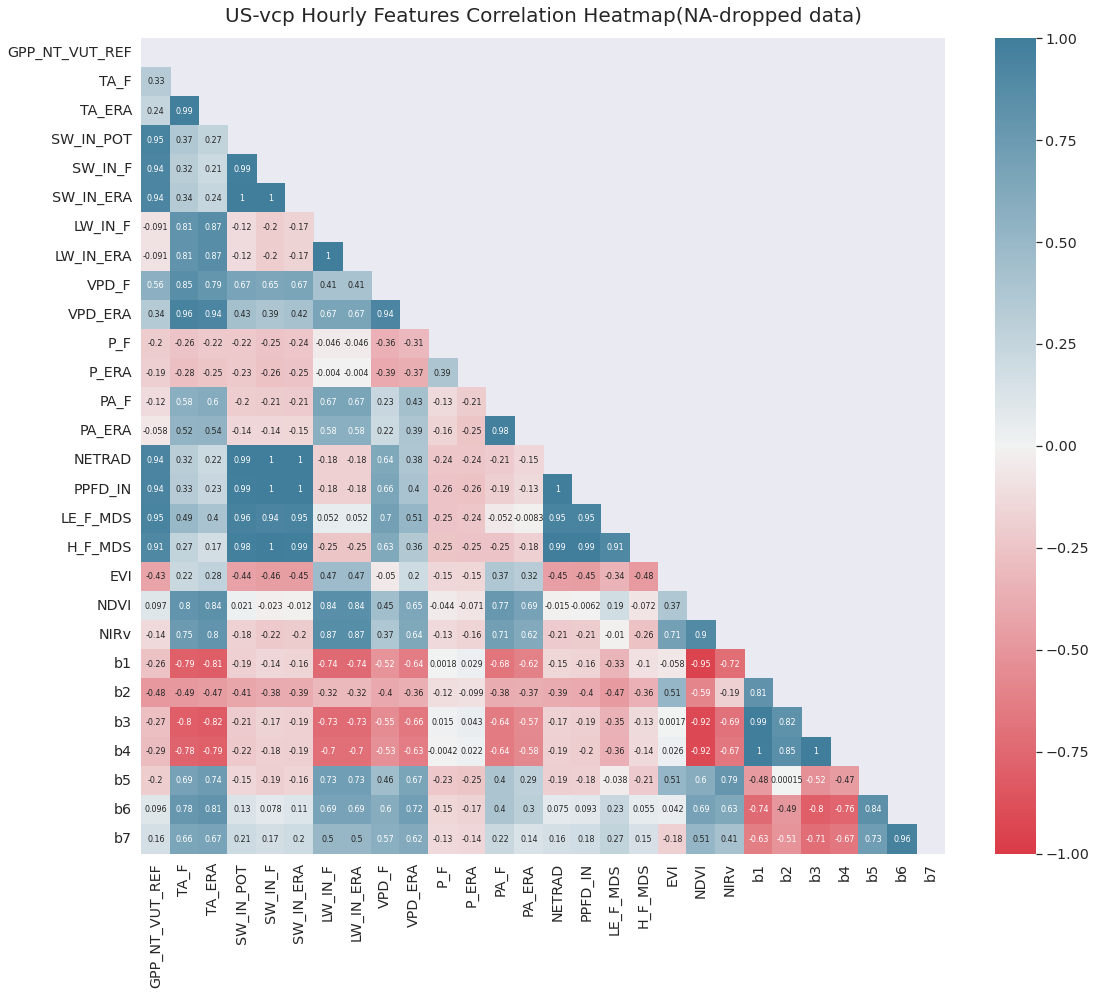

In [215]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(18, 15))

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_df3_NAdrop)

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.3)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":8}, mask=matrix)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':20}, pad=16)

plt.savefig("corr1.png",bbox_inches='tight')


### Another layout 

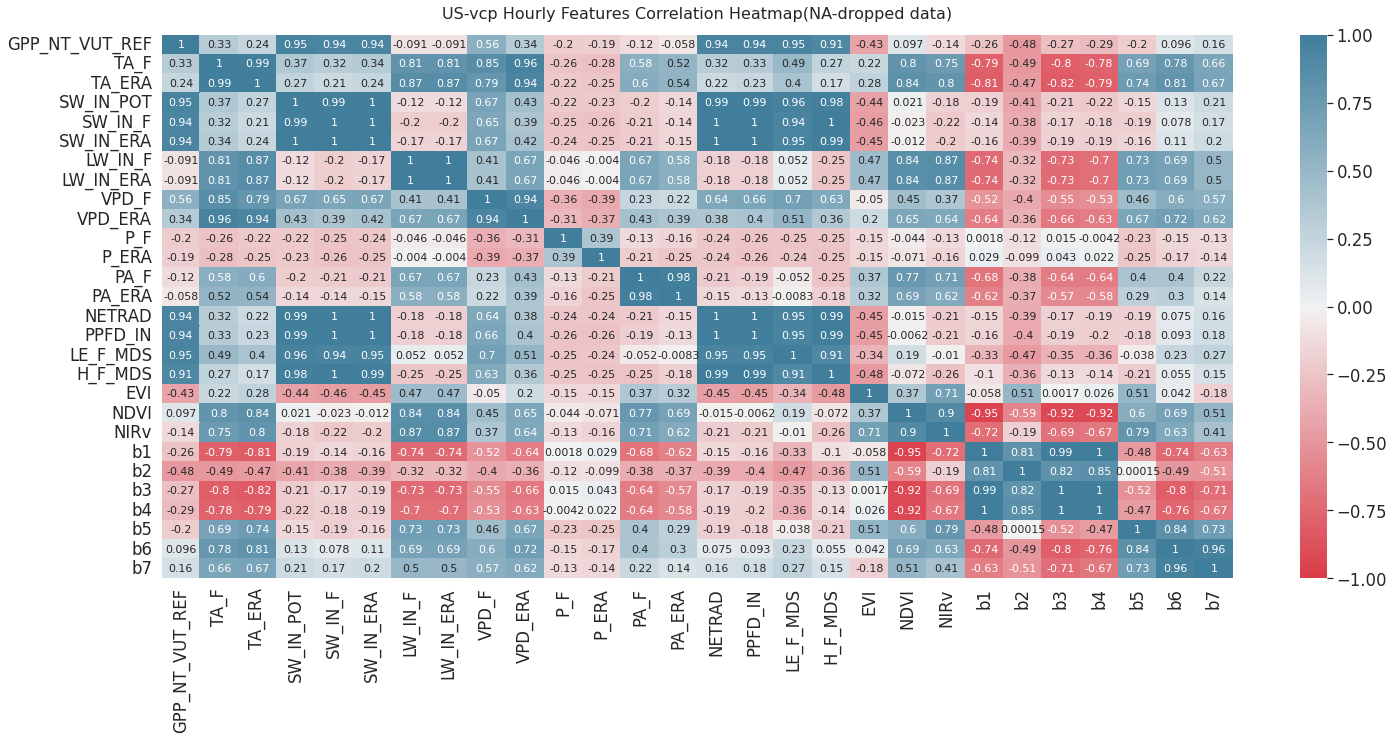

In [214]:
sns.set(style="darkgrid")
# Increase the size of the heatmap.
plt.figure(figsize=(24, 10))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
cmap = sns.diverging_palette(10, 230, as_cmap=True)
sns.set(font_scale=1.5)
heatmap = sns.heatmap(corr_df3_NAdrop.corr(), vmin=-1, vmax=1, annot=True, cmap=cmap,annot_kws={"fontsize":11})
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('US-vcp Hourly Features Correlation Heatmap(NA-dropped data)', fontdict={'fontsize':16}, pad=16)

plt.savefig("corr2.png",bbox_inches='tight')
